# 1. LeNet网络

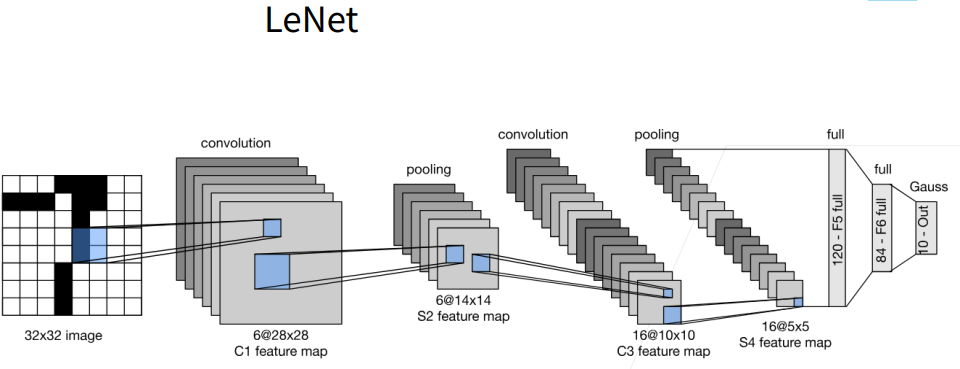

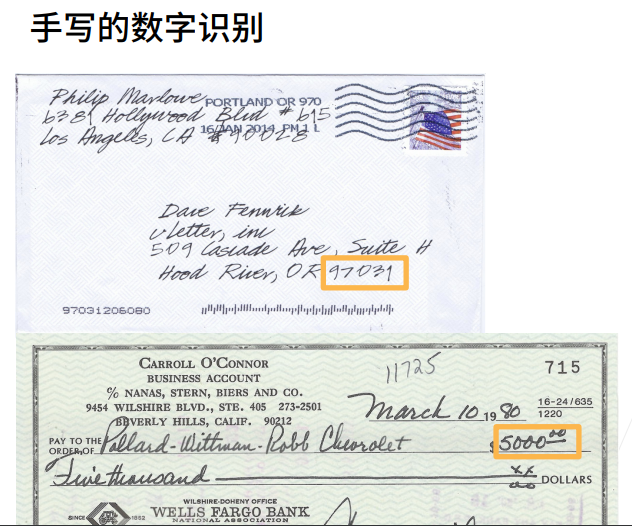

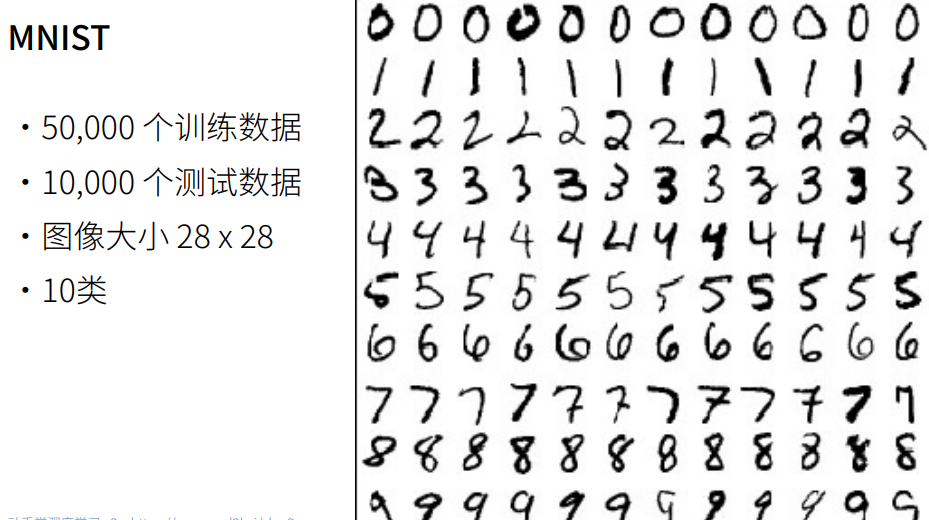

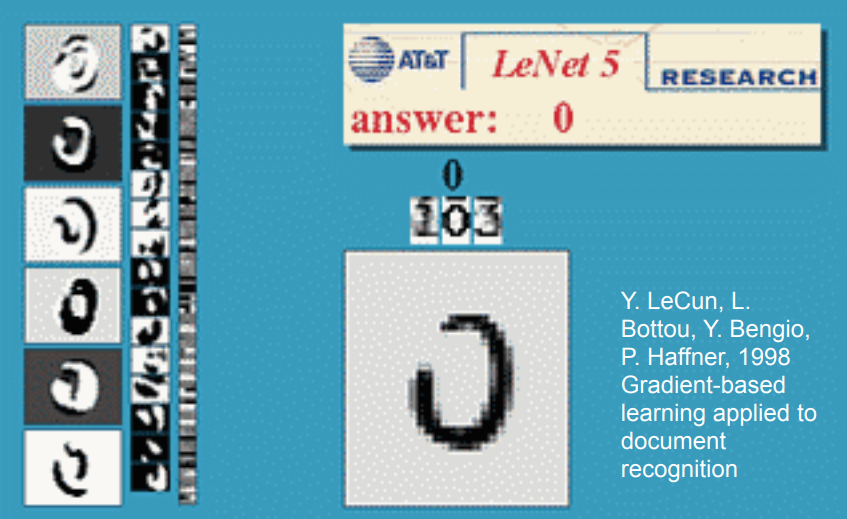

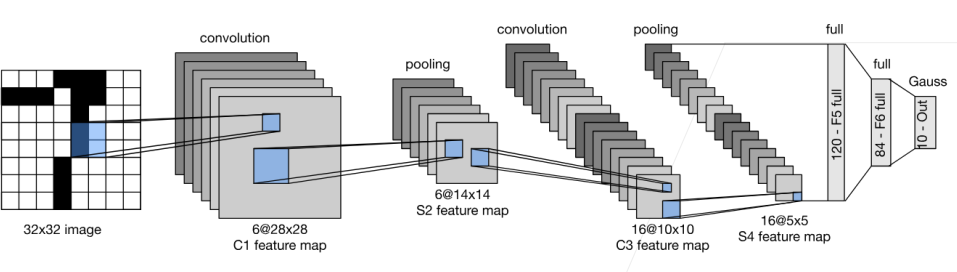

# 2. 总结

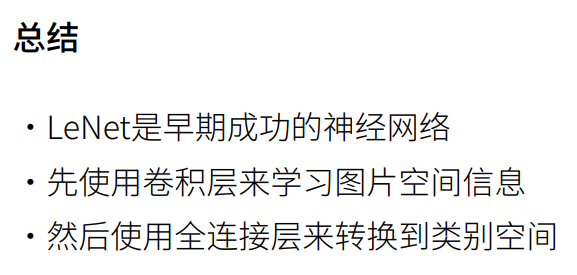

# 1. LeNet网络（使用自定义）

In [1]:
# LeNet(LeNet-5) 由两个部分组成：卷积编码器和全连接层密集块
import torch
from torch import nn
from d2l import torch as d2l

class Reshape(torch.nn.Module):
    def forward(self,x):
        return x.view(-1,1,28,28) # 批量数自适应得到，通道数为1，图片为28X28
    
net = torch.nn.Sequential(
        Reshape(), nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
        nn.AvgPool2d(2,stride=2),
        nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2,stride=2),nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
        nn.Linear(120, 84), nn.Sigmoid(),
        nn.Linear(84,10))

X = torch.rand(size=(1,1,28,28),dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape：\t',X.shape) # 上一层的输出为这一层的输入

Reshape output shape：	 torch.Size([1, 1, 28, 28])
Conv2d output shape：	 torch.Size([1, 6, 28, 28])
Sigmoid output shape：	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape：	 torch.Size([1, 6, 14, 14])
Conv2d output shape：	 torch.Size([1, 16, 10, 10])
Sigmoid output shape：	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape：	 torch.Size([1, 16, 5, 5])
Flatten output shape：	 torch.Size([1, 400])
Linear output shape：	 torch.Size([1, 120])
Sigmoid output shape：	 torch.Size([1, 120])
Linear output shape：	 torch.Size([1, 84])
Sigmoid output shape：	 torch.Size([1, 84])
Linear output shape：	 torch.Size([1, 10])


In [2]:
help(d2l.load_data_fashion_mnist)

Help on function load_data_fashion_mnist in module d2l.torch:

load_data_fashion_mnist(batch_size, resize=None)
    Download the Fashion-MNIST dataset and then load it into memory.



In [3]:
# LeNet在Fashion-MNIST数据集上的表现
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)    

In [4]:
# 对evaluate_accuracy函数进行轻微的修改
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # net.eval()开启验证模式，不用计算梯度和更新梯度
        if not device:
            device = next(iter(net.parameters())).device # 看net.parameters()中第一个元素的device为哪里
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X,list):
            X = [x.to(device) for x in X] # 如果X是个List，则把每个元素都移到device上
        else:
            X = X.to(device) # 如果X是一个Tensor，则只用移动一次，直接把X移动到device上
        y = y.to(device)
        metric.add(d2l.accuracy(net(X),y),y.numel()) # y.numel() 为y元素个数 
    return metric[0]/metric[1]

In [5]:
# 为了使用GPU，还需要一点小改动
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # 根据输入、输出大小，使得随即初始化后，输入和输出的的方差是差不多的              
            
    net.apply(init_weights)
    print('training on',device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(),lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],
                           legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        
        for i, (X,y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat,y),X.shape[0])                
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            
            if(i+1) % (num_batches//5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i+1) / num_batches,
                            (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        
    print(f'loss {train_l:.3f},train acc {train_acc:.3f},'
         f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec'
         f'on{str(device)}')

In [6]:
help(nn.init.xavier_uniform_)

Help on function xavier_uniform_ in module torch.nn.init:

xavier_uniform_(tensor:torch.Tensor, gain:float=1.0) -> torch.Tensor
    Fills the input `Tensor` with values according to the method
    described in `Understanding the difficulty of training deep feedforward
    neural networks` - Glorot, X. & Bengio, Y. (2010), using a uniform
    distribution. The resulting tensor will have values sampled from
    :math:`\mathcal{U}(-a, a)` where
    
    .. math::
        a = \text{gain} \times \sqrt{\frac{6}{\text{fan\_in} + \text{fan\_out}}}
    
    Also known as Glorot initialization.
    
    Args:
        tensor: an n-dimensional `torch.Tensor`
        gain: an optional scaling factor
    
    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.xavier_uniform_(w, gain=nn.init.calculate_gain('relu'))



loss 0.458,train acc 0.829,test acc 0.801
45859.5 examples/seconcuda:0


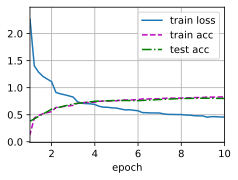

In [7]:
# 训练和评估LeNet-5模型
lr, num_epochs = 0.9, 10
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())